# AF SDK
* [GitHub PIthon](https://github.com/kenji0711/PIthon/blob/master/PIthon.py)
* 2 minutos para coletar 365d - 5m de dados. (105121 linhas)
* [AF SDK Manual](https://techsupport.osisoft.com/Documentation/PI-AF-SDK/Html/T_OSIsoft_AF_PI_PIPoint.htm)
* [Seach Method Query](https://techsupport.osisoft.com/Documentation/PI-AF-SDK/html/33f7ca86-dbca-4aea-951a-1fd72f8fb468.htm)

In [1]:
import sys  
import clr
import pandas as pd
import numpy as np

sys.path.append('C:\\Program Files (x86)\\PIPC\\AF\\PublicAssemblies\\4.0\\')  
clr.AddReference('OSIsoft.AFSDK')

clr.AddReference('System.Net') 
from System.Net import * 

from OSIsoft.AF import *
from OSIsoft.AF.PI import *  
from OSIsoft.AF.Search import *  
from OSIsoft.AF.Asset import *  
from OSIsoft.AF.Data import *  
from OSIsoft.AF.Time import *  
from OSIsoft.AF.EventFrame import *

In [2]:
class PI_AF():  
    def __init__(self):
        pass

    def connectAF(self):
        afServers = PISystems()
        afServer = afServers.DefaultPISystem
        login_AF = NetworkCredential('leonac53', '123456')
        afServer.Connect(login_AF)
        
        self.DB = afServer.Databases.get_Item('Confiabilidade')
        
    def connectPIServer(self):
        piServers = PIServers()  
        piServer = piServers.DefaultPIServer;

        login = NetworkCredential('eremoto', 'eremoto')
        piServer.Connect(login)

    def getEventFrames(self):
        DB = self.DB

        events = AFEventFrame.FindEventFrames(
            DB, #AF Database
            None, #AF reference
            AFTime.Now, #query
            0, #startIndex
            200, #maxCount
            AFEventFrameSearchMode.BackwardFromStartTime,
            None,
            None,
            None,
            None,
            False)

        
        eventos = [{'Evento':event.Name,
                    'Inicio':event.StartTime.ToString(),
                    'Fim':event.EndTime.ToString(),
                    'Reconhecido':event.IsAcknowledged,   # .ID,
                    'Elemento':event.PrimaryReferencedElement.ToString(),
                    'Template':event.Template.ToString(),
                    'Reconhecido em':event.AcknowledgedDate.ToString(),
                    'Reconhecido por':event.AcknowledgedBy
                    
                } 
                for event in events]

        df = pd.DataFrame(eventos)
        return df
    
    def getElement(self,element_name):
        return self.DB.Elements.get_Item(element_name)
    
    def getDFContextAttributes(self,elemento,StartTime="*-1d", EndTime="*", span="5m"):
        root = elemento # AF.Asset.AFElement.  Ex: PIAF.getElement('Controle Motores Elétricos').Elements.get_Item('2-YM-7004')
        
        # Seleciona atributos de categoria "Contexto"
        self.attributes_to_plot = []
        for attribute in root.Attributes:
            if attribute.CategoriesString == 'Contexto;': # seleciona somente variávies da categoria Contexto
                if attribute.PIPoint != None:             # confere se attributos possuem PIPoint
                    self.attributes_to_plot.append(attribute) #attribute.PIPoint # lista de PIPoints a serem plotados
        
        # Cria lista de PIPoints dos atributos
        PIPoint_List = PIPointList()
        for pipoint in self.attributes_to_plot: #melhorar nome da lista attribute_plot
            PIPoint_List.Add(pipoint.PIPoint)
        
        # Coleta dados através da função "InterpolatedValues" que retorna uma lista de AFValues
        timerange = AFTimeRange(StartTime, EndTime)
        span = AFTimeSpan.Parse(span)
        config = PIPagingConfiguration(PIPageType.TagCount, 100)
        
        self.AFvalues_List = PIPoint_List.InterpolatedValues(timerange, span, "", False,config) #Coleta dados do DataArquive e Retorna lista de AFValues
        #print('Qtd de pontos na lista:',PIPoint_List.Count)

        # Retira dados da lista e AFValues e transforma em DATAFRAME.
        series = []
        for AFValues, Attribute in zip(self.AFvalues_List, self.attributes_to_plot):
            serie = [{'index':AFValue.Timestamp.LocalTime, Attribute.Name: AFValue.Value} for AFValue in AFValues] #AFValue.PIPoint.Name
            serie = pd.DataFrame(serie).set_index('index')
            #serie = serie.apply(lambda x: pd.to_numeric(x,errors='coerce'))
            series.append(serie)
            #self.AFValue = AFValue.Value
            
        df = pd.concat(series, axis=1)
        return df
    


In [3]:
%%time
PIAF = PI_AF()
PIAF.connectAF()
PIAF.connectPIServer()
ele_1 = PIAF.getElement('PE9')
ele_2 = ele_1.Elements.get_Item('Linha2')
ele_3 = ele_2.Elements.get_Item('C-4301')
df = PIAF.getDFContextAttributes(ele_3,'-60d','15/05/2020')
df


Wall time: 46.2 s


,VAZAO SELAGEM PRIM,VAZAO VENT SELAGEM,PRESS REATOR 1,NIVEL TOPO REATOR,TEMP TOPO REATOR,TEMP AMBIENTE,DELT PRESS FILTR OLEO,PRESS OLEO LUB COMP,DESLOC MANC AXIAL 2,DESLOC MANC AXIAL 1,...,ABERT VALV FLARE,ABERT VALV PPB,GRADE REATOR,CARGA REATOR,PRESS DIFF COMPRESSOR,VAZAO COMP,DIFF TEMP COOLER,POTENCIA COMPRESSOR,TEMP DESC COMP,ABERT GUIDE VANE
index,,,,,,,,,,,,,,,,,,,,,
16/03/2020 00:00:00,-0.653902,-0.016932,1.072075,-1.064523,29.76033,26.86885,0.000816,-0.014778,117.4047,164.8304,...,0.0,0.00000,R2-PARADO,0.00000,-0.037094,0.178105,-2.390471,4.17122,29.68415,78.0
16/03/2020 00:05:00,-0.663422,-0.016821,1.072007,-1.064100,29.71132,26.86885,0.000740,-0.015145,117.4047,164.8304,...,0.0,0.00000,R2-PARADO,0.00000,-0.037451,0.250751,-2.463474,4.00027,29.67053,78.0
16/03/2020 00:10:00,-0.616763,-0.017695,1.071098,-1.069405,29.66065,26.86885,0.000740,-0.014940,117.4047,164.8915,...,0.0,0.00000,R2-PARADO,0.00000,-0.037094,0.323396,-2.449222,4.17122,29.63440,78.0
16/03/2020 00:15:00,-0.644559,-0.016791,1.070857,-1.067392,29.65580,26.86885,0.000664,-0.014734,117.4657,165.0135,...,0.0,0.00000,R2-PARADO,0.00000,-0.037094,0.003614,-2.525898,4.17122,29.58448,78.0
16/03/2020 00:20:00,-0.674953,-0.015571,1.069972,-1.064669,29.60359,26.86885,0.000702,-0.014528,117.4657,165.0746,...,0.0,0.00000,R2-PARADO,0.00000,-0.037094,0.015510,-2.528120,4.17122,29.56105,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14/05/2020 23:40:00,699.482100,2.766550,23.358560,5.177024,99.47063,20.95598,0.165309,1.384667,173.3146,224.0364,...,0.0,41.58334,DFX6034,29.02761,1.115916,1090.142000,16.376950,2477.8,108.98380,65.0
14/05/2020 23:45:00,700.442900,2.786113,23.323540,6.919125,99.47243,20.95598,0.165690,1.387508,172.8873,223.3040,...,0.0,41.03531,DFX6034,28.58644,1.121495,1090.870000,15.496560,2471.99,109.14400,65.0
14/05/2020 23:50:00,699.546900,2.780888,23.347400,6.123672,99.56184,20.95598,0.165995,1.385553,172.7653,223.5481,...,0.0,41.92996,DFX6034,28.64276,1.121710,1094.489000,15.228780,2478.31,109.20990,65.0


In [157]:
df.to_excel("dados60d.xlsx",
             sheet_name='Sheet1')  

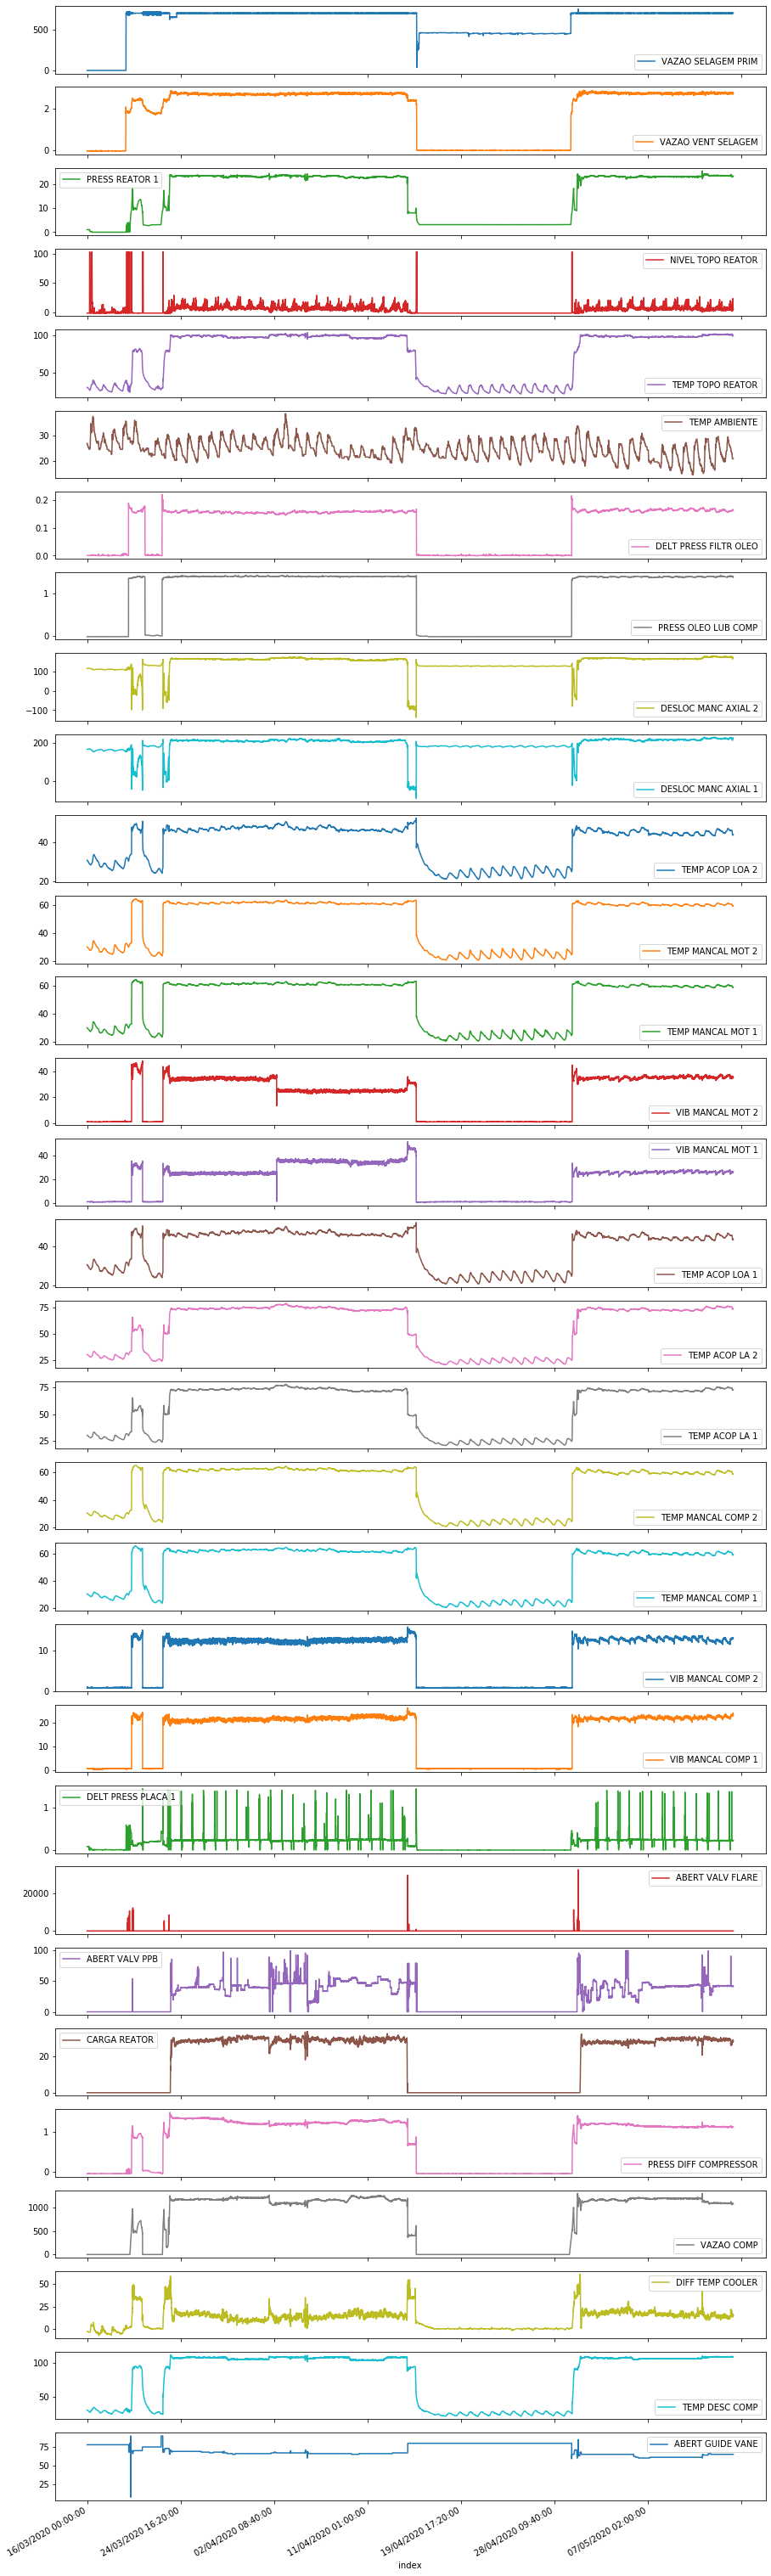

In [156]:
df.plot(figsize=(15,60),subplots=True);